# Project Description

## Import Libraries

In [1]:
import scjpnlib.utils as scjpnutils
from scjpnlib.utils import sql_manager as sqlmgr
import pandas as pd
import numpy as np
from IPython.core.display import HTML, Markdown
from scjpnlib.utils.file_io import FileManager
# import itertools as itimport itertools as it
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from scjpnlib.utils.skl_transformers import DropColumnsTransformer, StringCaseTransformer, SimpleValueTransformer, OneHotEncodingTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2

pysqldfmgr = sqlmgr.PySQLDFManager(globals())

## Obtain the Data

In [2]:
fm = FileManager()

ds_map = {
    'Taarifa-Test.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv', 
    'Taarifa-Train-Labels.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv',
    'Taarifa-Train.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
}

fm.validate_download(ds_map)

## Explore the Data

In [3]:
SEED = 42 # for random_state reproducability

In [4]:
labels = pd.read_csv('Taarifa-Train-Labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [5]:
X_unlabeled = pd.read_csv('Taarifa-Test.csv')
X_labeled = pd.read_csv('Taarifa-Train.csv')
X_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
#df_base = pd.concat([df_base_labels, df_base_X], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, labels.status_group, test_size=0.30, random_state=SEED)

classes = labels.status_group.unique()

In [7]:
y_train.value_counts()

functional                 22535
non functional             16021
functional needs repair     3024
Name: status_group, dtype: int64

In [8]:
scjpnutils.analyze_values(pd.DataFrame(y_train, columns=['status_group']), 'y_train')

,feature,dtype,n_unique,n_unique_ratio,unique_vals,p_cat,n_null,n_null_ratio,null_index
0,status_group,object,3,0.000072,"[non functional, functional, functional needs ...",99.99,0,0.0,None


In [9]:
scjpnutils.analyze_values(X_train, 'X_train')

,feature,dtype,n_unique,n_unique_ratio,unique_vals,p_cat,n_null,n_null_ratio,null_index
0,id,int64,41580,1.000000,"[9358, 31628, 15603, 37051, 52389, 13939, 6551...",0.00,0,0.000000,None
1,amount_tsh,float64,94,0.002261,"[500.0, 0.0, 30.0, 20.0, 5.0, 50.0, 1500.0, 11...",99.77,0,0.000000,None
2,date_recorded,object,346,0.008321,"[2011-04-15, 2011-07-21, 2013-03-30, 2011-03-2...",99.17,0,0.000000,None
3,funder,object,1585,0.038119,"[Roman Catholic, Unicef, Ncaa, Kkkt, Jaica, Da...",96.19,2527,0.060774,"Int64Index([17520, 55926, 50280, 41987, 54772,..."
4,gps_height,int64,2383,0.057311,"[1846, 0, 1840, 1202, 60, 1766, 1777, 1897, 24...",94.27,0,0.000000,None
5,installer,object,1804,0.043386,"[ACRA, UNICEF, NCAA, KKKT, JAICA, Danid, DWE, ...",95.66,2536,0.060991,"Int64Index([17520, 55926, 50280, 41987, 54772,..."
6,longitude,float64,40313,0.969529,"[34.80063627, 30.54399872, 35.27169615, 38.456...",3.05,0,0.000000,None
7,latitude,float64,40314,0.969553,"[-9.12980092, -2.78273991, -3.21620263, -4.910...",3.04,0,0.000000,None
8,wpt_name,object,27336,0.657431,"[Kwa Galusi Mwajombe, Kukahabwa, Polisi, Kwa M...",34.26,0,0.000000,None
9,num_private,int64,57,0.001371,"[0, 15, 7, 6, 8, 39, 47, 2, 102, 17, 111, 5, 3...",99.86,0,0.000000,None


<p><br><br>

<h2>Clean TRAINING Predictors</h2>

<p><br>
<h3>Drop Features that do NOT contribute to Classification</h3>

In [10]:
# date_recorded will not contribute to predicting pump failure
# id: pure identification
# wpt_name: seems to be identification as well
# scheme_name: seems to be identification (of the "scheme", which really appears to represent specific combinations of OTHER feature values)
# recorded_by: is constant for every observation and therefore will not contribute to classification
# subvillage: SEEMS to be for identification, not sure yet... but drop for now and reintegrate later ***this is the one from this list we may to reconider including in the model***
non_contrib_feats = feats_to_reintegrate_later = ['id', 'date_recorded', 'wpt_name', 'scheme_name', 'recorded_by', 'subvillage']
X_train_reintegrate_later = X_train[feats_to_reintegrate_later]

dct_non_contrib_predictors = DropColumnsTransformer(non_contrib_feats)
# basis for cleaned training predictors
X_train_clean = dct_non_contrib_predictors.fit_transform(X_train)

# do the same for throw-away X_test since we will use union of unique categories between it and X_train_clean for one-hot encoding (the same applies to X_unlabeled)
X_test_clean_throw_away = dct_non_contrib_predictors.fit_transform(X_test)
X_unlabeled_throw_away = dct_non_contrib_predictors.fit_transform(X_unlabeled)

<p><br>
<h3>Drop Features that DUPLICATE other Features</h3>

In [11]:
# The following seem to have similar data:
#    1. "region" features: region, region_code
#        superset/final: region_code; drop: region (but we might need to re-map region_code to region string for display later)
#    2. "extraction" features: extraction_type, extraction_type_group, extraction_type_class
#        superset/final: extraction_type; drop: extraction_type_group, extraction_type_class
#    3. "management" features: scheme_management, management, management_group
#        superset/final: scheme_management; drop: management, management_group
#    4. "payment" features: payment, payment_type
#        superset/final: payment; drop: payment_type
#    5. "quality" features: water_quality, quality_group
#        superset: water_quality; drop: quality_group
#    6. "quantity" features: quantity, quantity_group
#        superset/final: quantity; drop: quantity_group
#    7. "source" features: source, source_type, source_class
#        superset/final: source; drop: source_type, source_class
#    8. "waterpoint" features: waterpoint_type, waterpoint_type_group
#        superset/final: waterpoint_type; drop: waterpoint_type_group

dup_features_to_drop = [
    'region', 
    'extraction_type_group', 
    'extraction_type_class',
    'management',
    'management_group',
    'payment_type',
    'quality_group',
    'quantity_group',
    'source_type',
    'source_class',
    'waterpoint_type_group'
]

dct_dup_predictors = DropColumnsTransformer(dup_features_to_drop)
X_train_clean = dct_dup_predictors.fit_transform(X_train_clean)

# do the same for throw-away X_test since we will use union of unique categories between it and X_train_clean for one-hot encoding (the same applies to X_unlabeled)
X_test_clean_throw_away = dct_dup_predictors.fit_transform(X_test_clean_throw_away)
X_unlabeled_throw_away = dct_dup_predictors.fit_transform(X_unlabeled_throw_away)

<p><br>
<h3>Fix/replace NULL/MISSING values</h3>

<h4>funder:</h4>

In [12]:
# check to see if there is an appropriate value in df_base_X.funder to indicate null - e.g. 'None' or 'none'
values_found_at = np.where(X_labeled.funder==('None' or 'none'))[0]
if len(values_found_at) > 0:
    for idx in values_found_at:
        print(f"funder has '{X_labeled.iloc[idx].funder}' at index: {idx}")
else:
    print(f"no records found with ['None', 'none'] in funder values")

funder has 'None' at index: 4868
funder has 'None' at index: 19055


In [13]:
# so let's replace all null funder values with 'None'
replace_null_rules = {'funder': {'missing_values': np.nan, 'strategy': 'constant', 'fill_value': 'None'}}

<p><br>
<h4>installer:</h4>

In [14]:
# check to see if there is an appropriate value in df_base_X.installer to indicate null - e.g. 'None' or 'none'
values_found_at = np.where(X_labeled.installer==('None' or 'none'))[0]
if len(values_found_at) > 0:
    for idx in values_found_at:
        print(f"funder has '{X_labeled.iloc[idx].installer}' at index: {idx}")
else:
    print(f"no records found with ['None', 'none'] in installer values")

no records found with ['None', 'none'] in installer values


In [15]:
# there doesn't appear to be, so let's create this semantic and replace all null installer values with 'None'
replace_null_rules['installer'] = {
    'missing_values': np.nan,
    'strategy': 'constant', 
    'fill_value': 'None'
}

<p><br>
<h4>public_meeting:</h4>

In [16]:
# we see above that list of unique values for public_meeting is [True, nan, False] so we will replace nan (null) with False - we don't know that this is correct yet... default could be True
replace_null_rules['public_meeting'] = {
    'missing_values': np.nan,
    'strategy': 'constant', 
    'fill_value': False
}

<p><br>
<h4>scheme_management:</h4>

In [17]:
X_train_clean.scheme_management.unique()

array(['WUA', 'WUG', 'VWC', 'Private operator', 'Water Board',
       'Parastatal', 'Company', 'Water authority', nan, 'Other', 'SWC',
       'Trust', 'None'], dtype=object)

In [18]:
# we see above that list of unique values for scheme_management has 'None' so we will replace nan (null) with 'None'
replace_null_rules['scheme_management'] = {
    'missing_values': np.nan,
    'strategy': 'constant', 
    'fill_value': 'None'
}

<p><br>
<h4>permit:</h4>

In [19]:
# we see above that list of unique values for permit is [True, nan, False] so we will replace nan (null) with False
replace_null_rules['permit'] = {
    'missing_values': np.nan,
    'strategy': 'constant', 
    'fill_value': False
}

<p><br>
<h4>Now execute the above null-value replacement rules</h4>

In [20]:
nvt_null_predictors = SimpleValueTransformer(replace_null_rules)
X_train_clean = nvt_null_predictors.fit_transform(X_train_clean)

# do the same for throw-away X_test since we will use union of unique categories between it and X_train_clean for one-hot encoding (the same applies to X_unlabeled)
X_test_clean_throw_away = nvt_null_predictors.fit_transform(X_test_clean_throw_away)
X_unlabeled_throw_away = nvt_null_predictors.fit_transform(X_unlabeled_throw_away)

<p><br>
<h3>Re-examine Cleaned Predictors</h3>

In [21]:
scjpnutils.analyze_values(X_train_clean, 'X_train_clean')

,feature,dtype,n_unique,n_unique_ratio,unique_vals,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,94,0.002261,"[500.0, 0.0, 30.0, 20.0, 5.0, 50.0, 1500.0, 11...",99.77,0,0.0,None
1,funder,object,1584,0.038095,"[Roman Catholic, Unicef, Ncaa, Kkkt, Jaica, Da...",96.19,0,0.0,None
2,gps_height,int64,2383,0.057311,"[1846, 0, 1840, 1202, 60, 1766, 1777, 1897, 24...",94.27,0,0.0,None
3,installer,object,1804,0.043386,"[ACRA, UNICEF, NCAA, KKKT, JAICA, Danid, DWE, ...",95.66,0,0.0,None
4,longitude,float64,40313,0.969529,"[34.80063627, 30.54399872, 35.27169615, 38.456...",3.05,0,0.0,None
5,latitude,float64,40314,0.969553,"[-9.12980092, -2.78273991, -3.21620263, -4.910...",3.04,0,0.0,None
6,num_private,int64,57,0.001371,"[0, 15, 7, 6, 8, 39, 47, 2, 102, 17, 111, 5, 3...",99.86,0,0.0,None
7,basin,object,9,0.000216,"[Rufiji, Lake Victoria, Internal, Pangani, Wam...",99.98,0,0.0,None
8,region_code,int64,27,0.000649,"[11, 18, 2, 4, 60, 15, 19, 17, 1, 7, 3, 13, 80...",99.94,0,0.0,None
9,district_code,int64,20,0.000481,"[4, 30, 5, 1, 43, 2, 53, 8, 3, 13, 6, 33, 7, 2...",99.95,0,0.0,None


<p><br><br>
<h3>Identify and Prepare CATEGORICAL Features</h3>

In [22]:
# from above, it seems clear the following are categorical; for classifiers requiring one-hot encoding...
cat_feats = [
    'funder',
    'installer',
    'basin',
    'region_code',
    'district_code',
    'lga',
    'ward',
    'public_meeting',
    'scheme_management',
    'permit',
    'extraction_type',
    'payment',
    'water_quality',
    'quantity',
    'source',
    'waterpoint_type'
]

<h4>Check for Duplication after Normalizing to Lowercase</h4>

In [23]:
df_analysis = scjpnutils.analyze_values(X_train_clean, 'X_train_clean')
df_analysis.loc[df_analysis['dtype']==object][['feature', 'n_unique', 'unique_vals']]

,feature,n_unique,unique_vals
1,funder,1584,"[Roman Catholic, Unicef, Ncaa, Kkkt, Jaica, Da..."
3,installer,1804,"[ACRA, UNICEF, NCAA, KKKT, JAICA, Danid, DWE, ..."
7,basin,9,"[Rufiji, Lake Victoria, Internal, Pangani, Wam..."
10,lga,125,"[Njombe, Ngara, Ngorongoro, Lushoto, Mkuranga,..."
11,ward,2066,"[Mdandu, Bukiriro, Endulen, Funta, Vikindu, Ma..."
14,scheme_management,12,"[WUA, WUG, VWC, Private operator, Water Board,..."
17,extraction_type,18,"[gravity, india mark ii, mono, submersible, sw..."
18,payment,7,"[pay monthly, never pay, pay per bucket, pay a..."
19,water_quality,8,"[soft, salty, unknown, milky, fluoride, salty ..."
20,quantity,5,"[dry, enough, insufficient, seasonal, unknown]"


In [24]:
df_analysis = scjpnutils.analyze_values(X_train_clean, 'X_train_clean', normalize_lcase=True)
df_analysis.loc[df_analysis['dtype']==object][['feature', 'n_unique', 'unique_vals']]

,feature,n_unique,unique_vals
1,funder,1584,"[roman catholic, unicef, ncaa, kkkt, jaica, da..."
3,installer,1640,"[acra, unicef, ncaa, kkkt, jaica, danid, dwe, ..."
7,basin,9,"[rufiji, lake victoria, internal, pangani, wam..."
10,lga,125,"[njombe, ngara, ngorongoro, lushoto, mkuranga,..."
11,ward,2066,"[mdandu, bukiriro, endulen, funta, vikindu, ma..."
14,scheme_management,12,"[wua, wug, vwc, private operator, water board,..."
17,extraction_type,18,"[gravity, india mark ii, mono, submersible, sw..."
18,payment,7,"[pay monthly, never pay, pay per bucket, pay a..."
19,water_quality,8,"[soft, salty, unknown, milky, fluoride, salty ..."
20,quantity,5,"[dry, enough, insufficient, seasonal, unknown]"


We see that <b>installer</b> has fewer unique values when normalized to lower-case string values.

<p><br>
<h4>Normalize Strings to lower-case</h4>

In [25]:
impute_lcase = {}
for cat_feat in cat_feats:
    impute_lcase[cat_feat] = str.lower
sci_cat_predictors = StringCaseTransformer(impute_lcase)
X_train_clean = sci_cat_predictors.fit_transform(X_train_clean)

# do the same for throw-away X_test since we will use union of unique categories between it and X_train_clean for one-hot encoding (the same applies to X_unlabeled)
X_test_clean_throw_away = sci_cat_predictors.fit_transform(X_test_clean_throw_away)
X_unlabeled_throw_away = sci_cat_predictors.fit_transform(X_unlabeled_throw_away)

<p><br>
<h4>Check for Numeric Strings</h4>

In [26]:
str_feat_unique_numeric_string_vals, df_analysis = scjpnutils.analyze_numeric_strings(X_train_clean, 'X_train_clean');
str_feat_unique_numeric_string_vals, df_analysis = scjpnutils.analyze_numeric_strings(X_test_clean_throw_away, 'X_test_clean_throw_away');
str_feat_unique_numeric_string_vals, df_analysis = scjpnutils.analyze_numeric_strings(X_unlabeled_throw_away, 'X_unlabeled_throw_away');

,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,1584,551,"Int64Index([14285, 28616, 1440, 56475, 56897, 59276, 5886, 33788, 17680, 12539, ... 9348, 56418, 20463, 417, 37220, 20445, 32562, 29127, 11653, 39188], dtype='int64', length=551)"
3,installer,1640,551,"Int64Index([14285, 28616, 1440, 56475, 56897, 59276, 5886, 33788, 17680, 12539, ... 9348, 56418, 20463, 417, 37220, 20445, 32562, 29127, 11653, 39188], dtype='int64', length=551)"
7,basin,9,0,None
10,lga,125,0,None
11,ward,2066,0,None
14,scheme_management,12,0,None
17,extraction_type,18,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,1068,226,"Int64Index([ 8972, 51613, 47699, 15135, 53020, 38594, 15200, 29356, 3564, 49968, ... 7001, 33058, 20676, 55046, 54051, 55720, 54994, 4466, 7104, 29403], dtype='int64', length=226)"
3,installer,1056,226,"Int64Index([ 8972, 51613, 47699, 15135, 53020, 38594, 15200, 29356, 3564, 49968, ... 7001, 33058, 20676, 55046, 54051, 55720, 54994, 4466, 7104, 29403], dtype='int64', length=226)"
7,basin,9,0,None
10,lga,124,0,None
11,ward,1981,0,None
14,scheme_management,12,0,None
17,extraction_type,17,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,980,203,"Int64Index([ 20, 112, 315, 474, 564, 567, 578, 610, 634, 767, ... 14003, 14041, 14155, 14236, 14305, 14424, 14438, 14444, 14663, 14716], dtype='int64', length=203)"
3,installer,980,203,"Int64Index([ 20, 112, 315, 474, 564, 567, 578, 610, 634, 767, ... 14003, 14041, 14155, 14236, 14305, 14424, 14438, 14444, 14663, 14716], dtype='int64', length=203)"
7,basin,9,0,None
10,lga,125,0,None
11,ward,1959,0,None
14,scheme_management,12,0,None
17,extraction_type,17,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


Since we normalized strings to lower-case - in order to reduce the size of the set of unique values in preparation for OneHotEncoding - we will replace '0' with 'none'.

In [27]:
str_feats_with_0_str_replacement_rules = {
    'funder': {
        'missing_values': '0',
        'strategy': 'constant', 
        'fill_value': 'none'
    },
    'installer': {
        'missing_values': '0',
        'strategy': 'constant', 
        'fill_value': 'none'
    },
}
impute_none_str = SimpleValueTransformer(str_feats_with_0_str_replacement_rules)
X_train_clean = impute_none_str.fit_transform(X_train_clean)
X_test_clean_throw_away = impute_none_str.fit_transform(X_test_clean_throw_away)
X_unlabeled_throw_away = impute_none_str.fit_transform(X_unlabeled_throw_away)

# visual confirmation that is_numeric_str_index is None in X_train_clean
scjpnutils.analyze_numeric_strings(X_train_clean, 'X_train_clean');
scjpnutils.analyze_numeric_strings(X_test_clean_throw_away, 'X_test_clean_throw_away');
scjpnutils.analyze_numeric_strings(X_unlabeled_throw_away, 'X_unlabeled_throw_away');

,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,1583,0,None
3,installer,1639,0,None
7,basin,9,0,None
10,lga,125,0,None
11,ward,2066,0,None
14,scheme_management,12,0,None
17,extraction_type,18,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,1067,0,None
3,installer,1055,0,None
7,basin,9,0,None
10,lga,124,0,None
11,ward,1981,0,None
14,scheme_management,12,0,None
17,extraction_type,17,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


,feature,n_unique,n_is_numeric_str,is_numeric_str_index
1,funder,979,0,None
3,installer,979,0,None
7,basin,9,0,None
10,lga,125,0,None
11,ward,1959,0,None
14,scheme_management,12,0,None
17,extraction_type,17,0,None
18,payment,7,0,None
19,water_quality,8,0,None
20,quantity,5,0,None


<p><br>
<h4>One-Hot Encoding</h4>

In [28]:
# first find union of all CLEANED categories
ohe_categories = []
for cat_feat in cat_feats:
    categories_union = set()
    categories_for_feat__X_train_clean = set(X_train_clean[cat_feat].unique())
    categories_union |= categories_for_feat__X_train_clean
    categories_for_feat__X_test_clean_throw_away = set(X_test_clean_throw_away[cat_feat].unique())
    categories_union |= categories_for_feat__X_test_clean_throw_away
    categories_for_feat__X_unlabeled_throw_away = set(X_unlabeled_throw_away[cat_feat].unique())
    categories_union |= categories_for_feat__X_unlabeled_throw_away
    ohe_categories.append(list(categories_union))

ohe_cat_predictors = OneHotEncodingTransformer(cat_feats_to_encode=cat_feats, categories_by_feat_idx=ohe_categories)
X_train_clean_cat_dummies = ohe_cat_predictors.fit_transform(X_train_clean)
# X_train_clean_cat_dummies.columns = [col.replace(r'[^a-zA-Z0-9]', '_') + f"_i_{i}" for i, col in enumerate(X_train_clean_cat_dummies.columns)]
X_train_clean_cat_dummies.columns = [f"{i}" for i, col in enumerate(X_train_clean_cat_dummies.columns)]

X_train_clean_cat_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 43069 to 56422
Columns: 6635 entries, 0 to 6634
dtypes: float64(6635)
memory usage: 2.1 GB


<p><br><br>
<h3>Identify and Prepare CONTINUOUS (ordinal) Features</h3>

In [29]:
dct_cont_predictors_from_cat_predictors = DropColumnsTransformer(cat_feats)
X_train_clean_cont = dct_cont_predictors_from_cat_predictors.fit_transform(X_train_clean)
X_train_clean_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 43069 to 56422
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         41580 non-null  float64
 1   gps_height         41580 non-null  int64  
 2   longitude          41580 non-null  float64
 3   latitude           41580 non-null  float64
 4   num_private        41580 non-null  int64  
 5   population         41580 non-null  int64  
 6   construction_year  41580 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 2.5 MB


In [30]:
scjpnutils.analyze_values(X_train_clean_cont, 'X_train_clean_cont')

,feature,dtype,n_unique,n_unique_ratio,unique_vals,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,94,0.002261,"[500.0, 0.0, 30.0, 20.0, 5.0, 50.0, 1500.0, 11...",99.77,0,0.0,None
1,gps_height,int64,2383,0.057311,"[1846, 0, 1840, 1202, 60, 1766, 1777, 1897, 24...",94.27,0,0.0,None
2,longitude,float64,40313,0.969529,"[34.80063627, 30.54399872, 35.27169615, 38.456...",3.05,0,0.0,None
3,latitude,float64,40314,0.969553,"[-9.12980092, -2.78273991, -3.21620263, -4.910...",3.04,0,0.0,None
4,num_private,int64,57,0.001371,"[0, 15, 7, 6, 8, 39, 47, 2, 102, 17, 111, 5, 3...",99.86,0,0.0,None
5,population,int64,927,0.022294,"[45, 0, 135, 1, 1041, 250, 300, 90, 25, 40, 15...",97.77,0,0.0,None
6,construction_year,int64,55,0.001323,"[2009, 0, 2005, 1975, 2010, 1992, 1990, 1970, ...",99.87,0,0.0,None


But it is clear that each feature above is ordinal and NOT, in fact, categorical.

<p><br>
<h4>Consider Outliers</h4>

In [31]:
X_train_clean_cont.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,41580.000000,41580.000000,41580.000000,4.158000e+04,41580.000000,41580.000000,41580.000000
mean,327.861776,668.457119,34.115174,-5.712070e+00,0.513949,178.159307,1305.088480
std,3338.635977,692.792692,6.498510,2.939523e+00,13.574083,447.796478,950.207371
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.097706,-8.532648e+00,0.000000,0.000000,0.000000
50%,0.000000,370.000000,34.919000,-5.026709e+00,0.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.183936,-3.328922e+00,0.000000,213.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,15300.000000,2013.000000


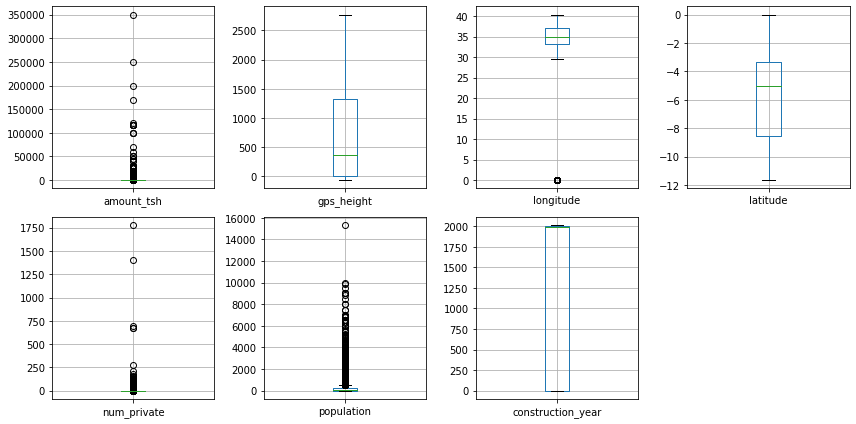

,feature,dtype,q1,q3,IQR_lower_bound,IQR_upper_bound,n_outliers,n_outliers_ratio,outliers_index
0,amount_tsh,float64,0.000000,20.000000,-30.000000,50.000000,7772,0.186917,"Int64Index([43069, 4010, 44017, 57811, 15917,..."
1,gps_height,int64,0.000000,1320.000000,-1980.000000,3300.000000,0,0.000000,"Int64Index([], dtype='int64')"
2,longitude,float64,33.097706,37.183936,26.968362,43.313280,1235,0.029702,"Int64Index([ 9233, 46444, 10123, 30975, 39356,..."
3,latitude,float64,-8.532648,-3.328922,-16.338238,4.476669,0,0.000000,"Int64Index([], dtype='int64')"
4,num_private,int64,0.000000,0.000000,0.000000,0.000000,547,0.013155,"Int64Index([30674, 5642, 6282, 30208, 23346,..."
5,population,int64,0.000000,213.000000,-319.500000,532.500000,3042,0.073160,"Int64Index([20944, 5642, 48592, 54772, 34777,..."
6,construction_year,int64,0.000000,2004.000000,-3006.000000,5010.000000,0,0.000000,"Int64Index([], dtype='int64')"


In [32]:
scjpnutils.analyze_outliers(X_train_clean_cont, 'X_train_clean_cont', display_plots=True, plot_edge=3)

There seem to be outlier continuous-feature values by IQR-computation standards.  But those outlier values seem to be meaningful so we will leave them be for now.

<p><br>
<h4>Scale</h4>

In [33]:
scaler = MinMaxScaler()
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_clean_cont), columns=X_train_clean_cont.columns, index=X_train_clean_cont.index)
scaled_X_train_cont.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,41580.000000,41580.000000,41580.000000,41580.000000,41580.000000,41580.000000,41580.000000
mean,0.000937,0.258192,0.845582,0.509670,0.000289,0.011644,0.648330
std,0.009539,0.244544,0.161073,0.252332,0.007643,0.029268,0.472035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.022238,0.820363,0.267549,0.000000,0.000000,0.000000
50%,0.000000,0.152842,0.865506,0.568502,0.000000,0.001634,0.986587
75%,0.000057,0.488175,0.921645,0.714242,0.000000,0.013922,0.995529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<p><br>
<h3>Final TRAINING Data</h3>
<h4>Prepare the Transformers Pipeline for Later Use (on TESTING data)</h4>

In [34]:
data_cleaner = Pipeline(
    steps=[
        ('drop_non_contrib', dct_non_contrib_predictors),
        ('drop_dup', dct_dup_predictors),
        ('null_imputer', nvt_null_predictors),
        ('lcase_imputer', sci_cat_predictors),
        ('none_str_imputer', impute_none_str)
    ]
)

# Categorical
categorical_transformer = Pipeline(
    steps=[
        ('data_cleaner', data_cleaner),
        ('ohe', ohe_cat_predictors)
    ] 
)

# Continuous
continuous_transformer = Pipeline(
    steps=[
        ('data_cleaner', data_cleaner),
        ('cont_from_cat', dct_cont_predictors_from_cat_predictors),
        ('scaler', scaler)
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_feats), 
        ('cont', continuous_transformer, cat_feats) # note that we pass in list of cat_feats since cont_feats are assumed to be the complement
    ]
)

<p><br>
<h4>Test the Transformers Pipeline</h4>

In [35]:
#data_train = preprocessor.fit_transform()

# for now
data_train = pd.concat([X_train_clean_cat_dummies, scaled_X_train_cont], axis=1, join='inner')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 43069 to 56422
Columns: 6642 entries, 0 to construction_year
dtypes: float64(6642)
memory usage: 2.1 GB


<p><br><br>
<h2>Clean TEST Predictors</h2>

<h3>Categorical</h3>

In [36]:
# test
# X_test_clean = categorical_transformer.fit_transform(X_test)
#scjpnutils.analyze_values(X_test_clean, 'X_test_clean')

X_test_clean_cat_dummies = categorical_transformer.fit_transform(X_test).set_index(X_test.index)
# X_test_clean_cat_dummies.columns = [col.replace(r'[^a-zA-Z0-9]', '_') + f"_i_{i}" for i, col in enumerate(X_test_clean_cat_dummies.columns)]
X_test_clean_cat_dummies.columns = [f"{i}" for i, col in enumerate(X_test_clean_cat_dummies.columns)]
# X_test_clean_cat_dummies = X_test_clean_cat_dummies.astype(int)

X_test_clean_cat_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17820 entries, 2980 to 41923
Columns: 6635 entries, 0 to 6634
dtypes: float64(6635)
memory usage: 902.2 MB


<p><br>
<h3>Continuous</h3>

In [37]:
# test
scaled_X_test_cont = pd.DataFrame(continuous_transformer.transform(X_test), columns=X_train_clean_cont.columns, index=X_test.index)

scaled_X_test_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17820 entries, 2980 to 41923
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         17820 non-null  float64
 1   gps_height         17820 non-null  float64
 2   longitude          17820 non-null  float64
 3   latitude           17820 non-null  float64
 4   num_private        17820 non-null  float64
 5   population         17820 non-null  float64
 6   construction_year  17820 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


<p><br>
<h3>Final TESTING Data</h3>

In [38]:
data_test = pd.concat([X_test_clean_cat_dummies, scaled_X_test_cont], axis=1, join='inner')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17820 entries, 2980 to 41923
Columns: 6642 entries, 0 to construction_year
dtypes: float64(6642)
memory usage: 903.2 MB


In [39]:
# data_test = preprocessor.fit_transform(X_test)

<br><br>
<h2>Build Classification Models</h2>

In [40]:
SEED = 42

<h3>Random Forest</h3>

In [41]:
clf = RandomForestClassifier(
    criterion = 'gini',
    n_estimators=100, 
    max_depth=None,
    random_state=SEED, 
    n_jobs=-1,
    verbose=1
)
clf.fit(data_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

<h4>Predictions</h4>

<h5>TRAINING Data</h5>

In [42]:
pred_train = clf.predict(data_train)
print("\n", clf.score(data_train, y_train), "\n")
print(classification_report(y_train, pred_train, target_names=classes))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished

 0.9982924482924483 

                         precision    recall  f1-score   support

             functional       1.00      1.00      1.00     22535
         non functional       0.99      0.99      0.99      3024
functional needs repair       1.00      1.00      1.00     16021

               accuracy                           1.00     41580
              macro avg       1.00      1.00      1.00     41580
           weighted avg       1.00      1.00      1.00     41580



<h5>TESTING Data</h5>

In [43]:
pred_test = clf.predict(data_test)
print("\n", clf.score(data_test, y_test), "\n")
print(classification_report(y_test, pred_test, target_names=classes))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished

 0.8046576879910213 

                         precision    recall  f1-score   support

             functional       0.82      0.87      0.84      9724
         non functional       0.52      0.37      0.43      1293
functional needs repair       0.83      0.79      0.81      6803

               accuracy                           0.80     17820
              macro avg       0.72      0.68      0.70     17820
           weighted avg       0.80      0.80      0.80     17820



<p><br>
<h3>XGBoost</h3>

In [45]:
from sklearn.preprocessing import LabelEncoder

K = 5

# clf = XGBClassifier(
#     objective='multi:softmax', 
#     num_classes=len(classes), 
#     n_estimators=100, 
#     # max_depth=None, 
#     silent=0,
#     random_state=SEED,
#     n_jobs=-1,
#     verbose=1
# )
# clf.fit(data_train, y_train)

param_grid = {
    "learning_rate": [0.1, 0.3, 0.6, 1.0],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.1, 0.5, 1.0],
    'n_estimators': [10, 30, 100]
}
clf = XGBClassifier(random_state=SEED)
grid_clf = GridSearchCV(clf, param_grid, cv=K)
grid_clf.fit(data_traindata_train, y_train)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

clf = XGBClassifier(
    learning_rate=best_parameters['learning_rate'],
    max_depth=best_parameters['max_depth'],
    min_child_weight=best_parameters['min_child_weight'],
    subsample=best_parameters['min_child_weight'],
    n_estimators=best_parameters['n_estimators'],
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, num_classes=3, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=0, subsample=1, verbose=1, verbosity=1)

In [48]:
pred_train = clf.predict(data_train)
print("\n", clf.score(data_train, y_train), "\n")
training_accuracy = accuracy_score(y_train, pred_train)
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print(classification_report(y_train, pred_train, target_names=classes))


 0.7513227513227513 

                         precision    recall  f1-score   support

             functional       0.71      0.94      0.81     22535
         non functional       0.69      0.13      0.22      3024
functional needs repair       0.85      0.61      0.71     16021

               accuracy                           0.75     41580
              macro avg       0.75      0.56      0.58     41580
           weighted avg       0.77      0.75      0.73     41580

Training Accuracy: 75.13%


In [49]:
pred_test = clf.predict(data_test)
print("\n", clf.score(data_test, y_test), "\n")
testing_accuracy = accuracy_score(y_test, pred_test)
print("Testing Accuracy: {:.4}%".format(testing_accuracy * 100))
print(classification_report(y_test, pred_test, target_names=classes))


 0.7483726150392817 

                         precision    recall  f1-score   support

             functional       0.71      0.93      0.81      9724
         non functional       0.67      0.13      0.22      1293
functional needs repair       0.84      0.60      0.70      6803

               accuracy                           0.75     17820
              macro avg       0.74      0.55      0.58     17820
           weighted avg       0.76      0.75      0.73     17820

Testing Accuracy: 74.84%
